In [1]:
import numpy as np
import torch
import copy


In [2]:
a = torch.arange(1, 6, dtype=torch.float32)   # default: device = 'cpu'
b = a * a[:, None]
print(b)
print(b.shape)      # same as b.size()
print(b.stride())      # jump size is not given in bytes, but in number of items
print(b.dtype)
print(b.itemsize)
print(b.numel())    # same as size in numpy
print(b.device)
print(b.ndim)


tensor([[ 1.,  2.,  3.,  4.,  5.],
        [ 2.,  4.,  6.,  8., 10.],
        [ 3.,  6.,  9., 12., 15.],
        [ 4.,  8., 12., 16., 20.],
        [ 5., 10., 15., 20., 25.]])
torch.Size([5, 5])
(5, 1)
torch.float32
4
25
cpu
2


In [4]:
print(b[:,::2].stride())         # basic indexing:  view
print(b[[1,3],::2].stride())     # advanced indexing: copy


(5, 2)
(3, 1)


In [ ]:
c = b.to(torch.int64)    # similar to ndarray.astype()
print(c)
print()

d = c.numpy()            # numpy ndarray -> torch tensor conversion, does not copy memory by default (dtype, layout must be supported)
print(d)
print()

e = torch.from_numpy(d)  # torch tensor -> numpy ndarray conversion, does not copy memory by default (dtype, layout must be supported)
print(e)


tensor([[ 1,  2,  3,  4,  5],
        [ 2,  4,  6,  8, 10],
        [ 3,  6,  9, 12, 15],
        [ 4,  8, 12, 16, 20],
        [ 5, 10, 15, 20, 25]])

[[ 1  2  3  4  5]
 [ 2  4  6  8 10]
 [ 3  6  9 12 15]
 [ 4  8 12 16 20]
 [ 5 10 15 20 25]]

tensor([[ 1,  2,  3,  4,  5],
        [ 2,  4,  6,  8, 10],
        [ 3,  6,  9, 12, 15],
        [ 4,  8, 12, 16, 20],
        [ 5, 10, 15, 20, 25]])


In [ ]:
print(torch.mean(b, dim=0))     # 'axis' or 'dim' - same functionality, but 'dim' is the original in pytorch
print(torch.mean(b, axis=0))
print(torch.mean(b, axis=1, keepdim=True))


tensor([ 3.,  6.,  9., 12., 15.])
tensor([ 3.,  6.,  9., 12., 15.])
tensor([[ 3.],
        [ 6.],
        [ 9.],
        [12.],
        [15.]])


In [ ]:
#print(b[:,::-1])    # raises "ValueError: step must be greater than zero" -> no negative strides in torch
print(torch.flip(b, dims=(1,)))   # not a view, but a copy


tensor([[ 5.,  4.,  3.,  2.,  1.],
        [10.,  8.,  6.,  4.,  2.],
        [15., 12.,  9.,  6.,  3.],
        [20., 16., 12.,  8.,  4.],
        [25., 20., 15., 10.,  5.]])


In [ ]:
a = torch.tensor([7.], dtype=torch.float32, requires_grad=True)
b = torch.tensor([11.], dtype=torch.float32, requires_grad=True)
q = a ** 2
z = q + 3*b

dz_da = torch.autograd.grad(z, a)   # 1*2*a
dz_dq = torch.autograd.grad(z, q)   # 1
#dq_da = torch.autograd.grad(q, a)   # 2*a   # raises "RuntimeError: Trying to backward through the graph a second time ..."
                                            #     use all previous autograd.grad() or backward() calls with 'retain_graph=True' argument
                                            #     otherwise intermediate gradient tensors are not kept
print('a:', a)
print('∂z/∂a:', dz_da)
print('∂z/∂q:', dz_dq)
#print('∂q/∂a:', dq_da)



a: tensor([7.], requires_grad=True)
∂z/∂a: (tensor([14.]),)
∂z/∂q: (tensor([1.]),)


# Adatbetöltés és konvertálás NumPy tömbre (vagy tenzorrá)

Adatbázis: Titanic Dataset - https://www.kaggle.com/datasets/yasserh/titanic-dataset (kiválasztandó az összes oszlop a teljes adatbázis böngészéséhez: "12 of 12 columns").

In [6]:
titanic_csv_url = 'https://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc25_p1/files/titanic.csv'

### Adatbetöltés, 1. opció: Fapados módszer, betöltés string-ként és feldolgozás

In [7]:
# Option#1: read file with urllib

import urllib

ftpstream = urllib.request.urlopen(titanic_csv_url)
dataset_content = ftpstream.read().decode('utf-8')
print(len(dataset_content))
print()
print(dataset_content[:500])


INPUT_VAR_NAMES = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
input_var_names_objarr = np.array(INPUT_VAR_NAMES, dtype=object)


61194

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S
6,0,3,"Moran, Mr. James",male,,0,0,330


In [ ]:
# replace a single comma from the Name field to not interfere with splitting the line at commas to get individual variable values

import re    # built-in regexp module
dataset_content = re.sub('"([^",]+),([^"]+)"', '"\g<1>\g<2>"', dataset_content)
print(len(dataset_content))
print()
print(dataset_content[:500])


60303

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S
2,1,1,"Cumings Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S
4,1,1,"Futrelle Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,0,3,"Allen Mr. William Henry",male,35,0,0,373450,8.05,,S
6,0,3,"Moran Mr. James",male,,0,0,330877,8.


In [ ]:
lines = dataset_content.split('\n')
lines_segmented = [line.split(',') for line in lines]   # list (lines) of lists (words in each line)
attr_names = lines_segmented[0]
data = lines_segmented[1:-1]
print(attr_names)
print(data[:3])


['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked\r']
[['1', '0', '3', '"Braund Mr. Owen Harris"', 'male', '22', '1', '0', 'A/5 21171', '7.25', '', 'S\r'], ['2', '1', '1', '"Cumings Mrs. John Bradley (Florence Briggs Thayer)"', 'female', '38', '1', '0', 'PC 17599', '71.2833', 'C85', 'C\r'], ['3', '1', '3', '"Heikkinen Miss. Laina"', 'female', '26', '0', '0', 'STON/O2. 3101282', '7.925', '', 'S\r']]


In [ ]:

# INPUT_VAR_NAMES = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
sex_dict = {'female': 0, 'male': 1}
embarked_dict = {'C': 0, 'Q': 1, 'S': 2}

dataset = []
for rec in data:
    dataset_row = []
    for item_idx, item in enumerate(rec):
        item = item.strip()    # remove whitespace \r, \n from the two ends of the string
        if item_idx in {1, 2, 5, 6, 7, 9}:
            val = float('nan') if item == '' else float(item)
        elif item_idx == 4:
            val = sex_dict[item]
        elif item_idx == 11:
            val = float('nan') if item == '' else embarked_dict[item]
        else:
            continue
        dataset_row.append(val)
    dataset.append(dataset_row)

print(dataset[:5])

[[0.0, 3.0, 1, 22.0, 1.0, 0.0, 7.25, 2], [1.0, 1.0, 0, 38.0, 1.0, 0.0, 71.2833, 0], [1.0, 3.0, 0, 26.0, 0.0, 0.0, 7.925, 2], [1.0, 1.0, 0, 35.0, 1.0, 0.0, 53.1, 2], [0.0, 3.0, 1, 35.0, 0.0, 0.0, 8.05, 2]]


In [ ]:

dataset_arr = np.array(dataset, dtype=np.float32)
print(dataset_arr[:5])
print(dataset_arr.shape)

inputs = dataset_arr[:,1:]
print(f"inputs array shape: {inputs.shape}, dtype: {inputs.dtype}")
print(inputs[:5, :])
labels = dataset_arr[:,0].astype(np.int32)
print(f"labels array shape: {labels.shape}, dtype: {labels.dtype}")
print(labels[:5])

[[ 0.      3.      1.     22.      1.      0.      7.25    2.    ]
 [ 1.      1.      0.     38.      1.      0.     71.2833  0.    ]
 [ 1.      3.      0.     26.      0.      0.      7.925   2.    ]
 [ 1.      1.      0.     35.      1.      0.     53.1     2.    ]
 [ 0.      3.      1.     35.      0.      0.      8.05    2.    ]]
(891, 8)
inputs array shape: (891, 7), dtype: float32
[[ 3.      1.     22.      1.      0.      7.25    2.    ]
 [ 1.      0.     38.      1.      0.     71.2833  0.    ]
 [ 3.      0.     26.      0.      0.      7.925   2.    ]
 [ 1.      0.     35.      1.      0.     53.1     2.    ]
 [ 3.      1.     35.      0.      0.      8.05    2.    ]]
labels array shape: (891,), dtype: int32
[0 1 1 1 0]


### Adatbetöltés, 2. opció: `csv` modul

In [ ]:
# Only in Colab: download file to Colab disk by using the bash command 'wget'
#   !wget https://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc25_p1/files/titanic.csv

In [ ]:
import csv

with open('titanic.csv', 'r') as file:
    my_reader = csv.reader(file, delimiter=',')
    attr_names = next(my_reader)
    print(attr_names)

    sex_dict = {'female': 0, 'male': 1}
    embarked_dict = {'C': 0, 'Q': 1, 'S': 2}

    dataset = []
    for row in my_reader:
        dataset_row = []
        for item_idx, item in enumerate(row):
            item = item.strip()
            if item_idx in {1, 2, 5, 6, 7, 9}:
                val = float('nan') if item == '' else float(item)
            elif item_idx == 4:
                val = sex_dict[item]
            elif item_idx == 11:
                val = float('nan') if item == '' else embarked_dict[item]
            else:
                continue
            dataset_row.append(val)
        dataset.append(dataset_row)


['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [ ]:

dataset_arr = np.array(dataset, dtype=np.float32)
print(dataset_arr[:5])
print()

inputs = dataset_arr[:,1:]
print(f"inputs array shape: {inputs.shape}, dtype: {inputs.dtype}")
print(inputs[:5, :])
labels = dataset_arr[:,0].astype(np.int32)
print(f"labels array shape: {labels.shape}, dtype: {labels.dtype}")
print(labels[:5])

[[ 0.      3.      1.     22.      1.      0.      7.25    2.    ]
 [ 1.      1.      0.     38.      1.      0.     71.2833  0.    ]
 [ 1.      3.      0.     26.      0.      0.      7.925   2.    ]
 [ 1.      1.      0.     35.      1.      0.     53.1     2.    ]
 [ 0.      3.      1.     35.      0.      0.      8.05    2.    ]]

inputs array shape: (891, 7), dtype: float32
[[ 3.      1.     22.      1.      0.      7.25    2.    ]
 [ 1.      0.     38.      1.      0.     71.2833  0.    ]
 [ 3.      0.     26.      0.      0.      7.925   2.    ]
 [ 1.      0.     35.      1.      0.     53.1     2.    ]
 [ 3.      1.     35.      0.      0.      8.05    2.    ]]
labels array shape: (891,), dtype: int32
[0 1 1 1 0]


### Adatbetöltés, 3. opció: Pandas könyvtár

In [ ]:
import pandas as pd
titanic_dataframe = pd.read_csv(titanic_csv_url)
titanic_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
titanic_dataframe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:

print("pd unique Sex: ", pd.unique(titanic_dataframe["Sex"]))
print("pd unique Embarked: ", pd.unique(titanic_dataframe["Embarked"]))

inputs1 = titanic_dataframe[["Pclass", "Age", "SibSp", "Parch", "Fare"]].to_numpy(dtype=np.float32)
inputs_sex = titanic_dataframe["Sex"].astype("category").cat.codes.to_numpy(dtype=np.float32)
inputs_emb = titanic_dataframe["Embarked"].astype("category").cat.codes.to_numpy(dtype=np.float32)
inputs_emb[inputs_emb == -1] = np.nan    # pandas converts NaNs into '-1' categorical label, now we set them back to NaN

print("np unique Sex: ", np.unique(inputs_sex))
print("np unique Embarked: ", np.unique(inputs_emb))
print()

print(f"inputs1 array shape: {inputs1.shape}, dtype: {inputs1.dtype}")
print(f"inputs_sex array shape: {inputs_sex.shape}, dtype: {inputs_sex.dtype}")
print(f"inputs3 array shape: {inputs_emb.shape}, dtype: {inputs_emb.dtype}")

# to mimic column order of previous dataset loading approaches
inputs = np.concatenate([inputs1[:,0,None], inputs_sex[:,None], inputs1[:,1:], inputs_emb[:,None]], axis=1)
print(f"\ninputs array shape: {inputs.shape}, dtype: {inputs.dtype}")

# Note:
#    inputs1[:,0]  -> (n_passengers,)
#    inputs1[:,[0]]  -> (n_passengers, 1)   advanced indexing - copy
#    inputs1[:,0,None]  -> (n_passengers, 1)   basic indexing - view

labels = titanic_dataframe["Survived"].to_numpy(dtype=np.int32)
print(f"labels array shape: {labels.shape}, dtype: {labels.dtype}")



pd unique Sex:  ['male' 'female']
pd unique Embarked:  ['S' 'C' 'Q' nan]
np unique Sex:  [0. 1.]
np unique Embarked:  [ 0.  1.  2. nan]

inputs1 array shape: (891, 5), dtype: float32
inputs_sex array shape: (891,), dtype: float32
inputs3 array shape: (891,), dtype: float32

inputs array shape: (891, 7), dtype: float32
labels array shape: (891,), dtype: int32


In [ ]:

print(f"inputs array shape: {inputs.shape}, dtype: {inputs.dtype}")
print(inputs[:5, :])
print(f"labels array shape: {labels.shape}, dtype: {labels.dtype}")
print(labels[:5])

inputs array shape: (891, 7), dtype: float32
[[ 3.      1.     22.      1.      0.      7.25    2.    ]
 [ 1.      0.     38.      1.      0.     71.2833  0.    ]
 [ 3.      0.     26.      0.      0.      7.925   2.    ]
 [ 1.      0.     35.      1.      0.     53.1     2.    ]
 [ 3.      1.     35.      0.      0.      8.05    2.    ]]
labels array shape: (891,), dtype: int32
[0 1 1 1 0]


# Adatexploráció

In [ ]:
# NaN values in which columns

# inputs: (n_passengers=891, n_variables=7), labels: (n_passengers=891,)

print("A few input examples:\n", inputs[:5,:])
print("A few labels:", labels[:5])
print()
print("Any NaNs in inputs?", np.any(np.isnan(inputs)))
print("Any NaNs in labels?", np.any(np.isnan(labels)))

print("Which variables (columns) indices have NaNs in inputs?", np.where(np.any(np.isnan(inputs), axis=0))[0])
print("Which variables (columns) by name have NaNs in inputs?", input_var_names_objarr[np.any(np.isnan(inputs), axis=0)])

print("How many NaNs are in the input?", np.count_nonzero(np.isnan(inputs), axis=0))


A few input examples:
 [[ 3.      1.     22.      1.      0.      7.25    2.    ]
 [ 1.      0.     38.      1.      0.     71.2833  0.    ]
 [ 3.      0.     26.      0.      0.      7.925   2.    ]
 [ 1.      0.     35.      1.      0.     53.1     2.    ]
 [ 3.      1.     35.      0.      0.      8.05    2.    ]]
A few labels: [0 1 1 1 0]

Any NaNs in inputs? True
Any NaNs in labels? False
Which variables (columns) indices have NaNs in inputs? [2 6]
Which variables (columns) by name have NaNs in inputs? ['Age' 'Embarked']
How many NaNs are in the input? [  0   0 177   0   0   0   2]


Column index of 'Pclass' var in dataset: 0
Unique 'Pclass' values: [1. 2. 3.] , counts: [216 184 491]


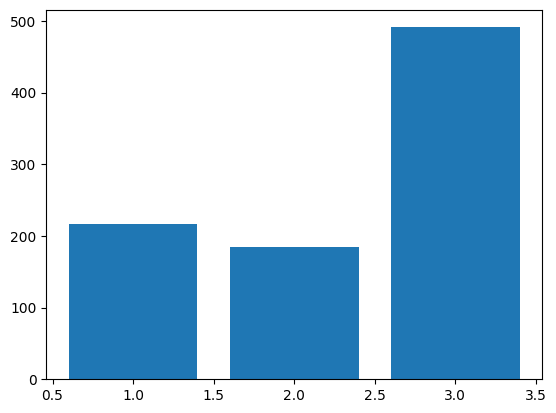

In [ ]:
# plot distribution of a variable with only a few elements on a barchart (passenger class distribution)
import matplotlib.pyplot as plt

assert inputs.shape[1] == len(INPUT_VAR_NAMES)
pclass_var_idx = INPUT_VAR_NAMES.index('Pclass')
print("Column index of 'Pclass' var in dataset:", pclass_var_idx)

u_pclass_var_vals, count_pclass_var_vals = np.unique(inputs[:,pclass_var_idx], return_counts=True)
print("Unique 'Pclass' values:", u_pclass_var_vals, ", counts:", count_pclass_var_vals)

plt.bar(u_pclass_var_vals, count_pclass_var_vals)
plt.show()


Uunique 'Pclass' values for females only: [1. 2. 3.] , counts: [ 94  76 144]
Uunique 'Pclass' values for males only: [1. 2. 3.] , counts: [122 108 347]


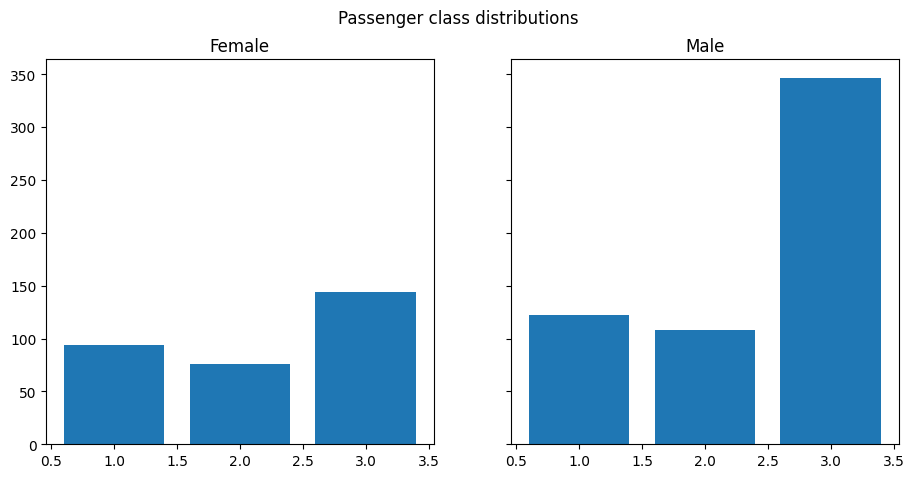

In [ ]:
# Multiple barcharts showing passenger class distribution of males and females separately

assert inputs.shape[1] == len(INPUT_VAR_NAMES)
pclass_var_idx = INPUT_VAR_NAMES.index('Pclass')    # 1, 2 or 3
sex_var_idx = INPUT_VAR_NAMES.index('Sex')          # female: 0, male: 1

females_mask = inputs[:, sex_var_idx] == 0

u_fem_pclass_var_vals, count_fem_pclass_var_vals = np.unique(inputs[females_mask, pclass_var_idx], return_counts=True)
print("Uunique 'Pclass' values for females only:", u_fem_pclass_var_vals, ", counts:", count_fem_pclass_var_vals)
u_male_pclass_var_vals, count_male_pclass_var_vals = np.unique(inputs[~females_mask, pclass_var_idx], return_counts=True)
print("Uunique 'Pclass' values for males only:", u_male_pclass_var_vals, ", counts:", count_male_pclass_var_vals)

figure, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(11,5))
axes[0].bar(u_fem_pclass_var_vals, count_fem_pclass_var_vals)
axes[0].set_title('Female')
axes[1].bar(u_male_pclass_var_vals, count_male_pclass_var_vals)
axes[1].set_title('Male')
figure.suptitle('Passenger class distributions')
plt.show()


Histogram of age distribution of males who survived:
    bin edges: [ 0.42   8.378 16.336 24.294 32.252 40.21  48.168 56.126 64.084 72.042
 80.   ]
    bin counts: [17  5 11 29 13  9  6  2  0  1]



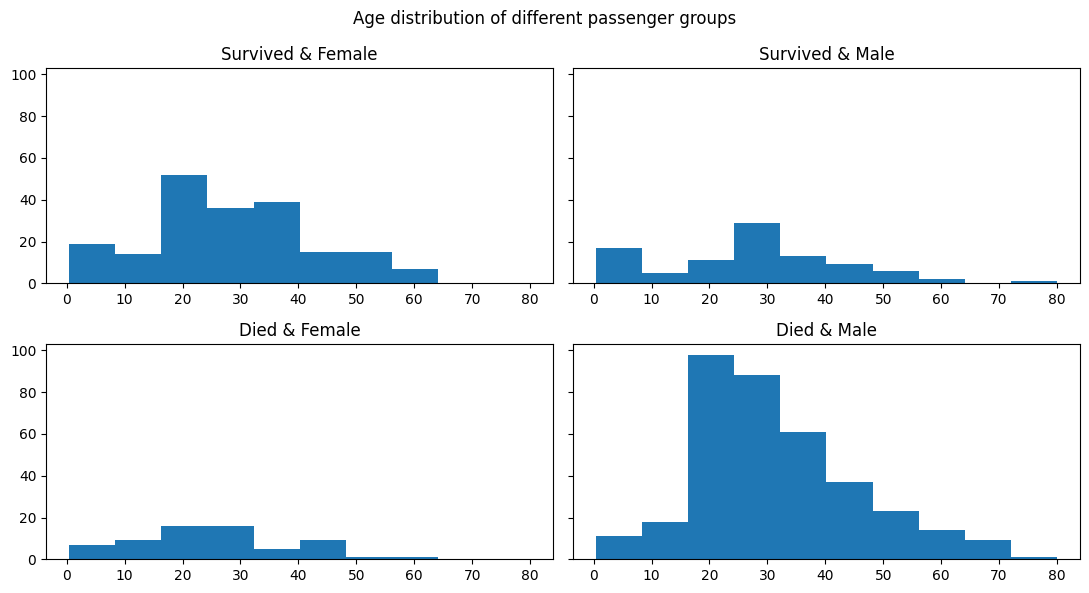

In [ ]:
# histograms to show age distribution of men/women who survived or not survived
#     there are a lot of different age values, so counting individual values is not informative
#     -> instead count people falling into given age intervals -> histogram

assert inputs.shape[1] == len(INPUT_VAR_NAMES)
age_var_idx = INPUT_VAR_NAMES.index('Age')
sex_var_idx = INPUT_VAR_NAMES.index('Sex')          # female: 0, male: 1

females_mask = inputs[:, sex_var_idx] == 0
survived_mask = labels == 1

min_age, max_age = np.nanmin(inputs[:, age_var_idx]), np.nanmax(inputs[:, age_var_idx])   # ignoring NaNs where age is missing

# example histogram: age distribution of males who survived
# setting histogram ends explicitly to have similar intervals for each group (alternative: np.histogram_bin_edges)
males_survived_mask = ~females_mask & survived_mask
hist, bin_edges = np.histogram(inputs[males_survived_mask, age_var_idx], range=(min_age, max_age))

print("Histogram of age distribution of males who survived:")
print("    bin edges:", bin_edges)
print("    bin counts:", hist)
print()

# (option#1: np.histogram & plt.bar)
# option#2: plt.hist

age_values_grouped = np.array([[inputs[females_mask & survived_mask, age_var_idx], inputs[~females_mask & survived_mask, age_var_idx]],
                               [inputs[females_mask & ~survived_mask, age_var_idx], inputs[~females_mask & ~survived_mask, age_var_idx]]], dtype=object)

N_BINS = 10
PLOT_TITLE_ROWS = ['Survived', 'Died']
PLOT_TITLE_COLS = ['Female', 'Male']

fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, tight_layout=True, figsize=(11,6))
fig.suptitle('Age distribution of different passenger groups')
for row_idx in range(2):
    for col_idx in range(2):
        axs[row_idx, col_idx].hist(age_values_grouped[row_idx, col_idx], bins=N_BINS, range=(min_age, max_age))
        axs[row_idx, col_idx].set_title(PLOT_TITLE_ROWS[row_idx] + ' & ' + PLOT_TITLE_COLS[col_idx])
plt.show()



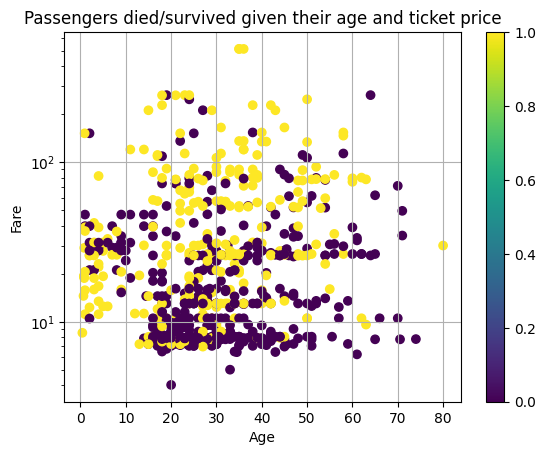

In [ ]:
# Scatter plot of two vars & label: passenger age vs. passenger fare (price of ticket), dots colored according to label

assert inputs.shape[1] == len(INPUT_VAR_NAMES)
age_var_idx = INPUT_VAR_NAMES.index('Age')
fare_var_idx = INPUT_VAR_NAMES.index('Fare')
#valid_mask = ~np.isnan(inputs[:, age_var_idx])

plt.scatter(inputs[:, age_var_idx], inputs[:, fare_var_idx], c=labels, cmap='viridis', label=labels)
plt.colorbar()
plt.title('Passengers died/survived given their age and ticket price')
plt.grid(True)
plt.xlabel('Age')
plt.ylabel('Fare')
plt.yscale('log')   # logscale on Fare
plt.show()


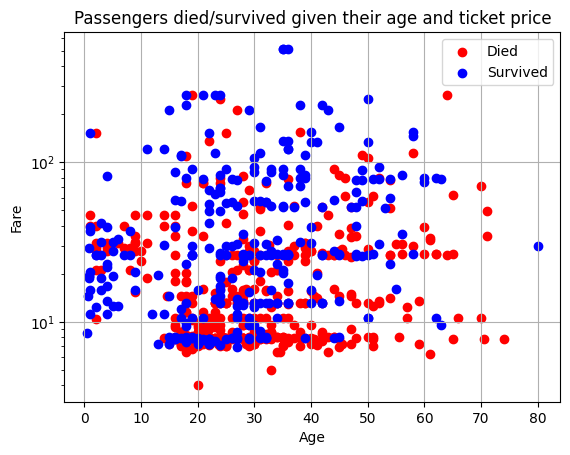

In [ ]:
# same scatter plot with legend instead of colorbar

assert inputs.shape[1] == len(INPUT_VAR_NAMES)
age_var_idx = INPUT_VAR_NAMES.index('Age')
fare_var_idx = INPUT_VAR_NAMES.index('Fare')
survived_mask = labels == 1
inputs_survived = inputs[survived_mask, :]
inputs_died = inputs[~survived_mask, :]
#valid_mask = ~np.isnan(inputs[:, age_var_idx])

plt.scatter(inputs_died[:, age_var_idx], inputs_died[:, fare_var_idx], c='red', label='Died')
plt.scatter(inputs_survived[:, age_var_idx], inputs_survived[:, fare_var_idx], c='blue', label='Survived')
plt.legend()
plt.title('Passengers died/survived given their age and ticket price')
plt.grid(True)
plt.xlabel('Age')
plt.ylabel('Fare')
plt.yscale('log')   # logscale on Fare
plt.show()


In [ ]:
# Other plot types worth checking:
#    plt.plot (line plot, dot plot)
#    plt.pcolormesh (heatmap)
#    plt.matshow/plt.imshow (2D histogram, heatmap, confusion matrix, etc.)

# Adat előfeldolgozás

In [ ]:
# filtering NaNs, option #1: drop data points with NaNs
#     alternative: drop columns with NaNs, or a combination

def filtering_option1(inputs, labels):
    passengers_with_nan = np.any(np.isnan(inputs), axis=1)
    inputs = inputs[~passengers_with_nan, :]
    labels = labels[~passengers_with_nan]

    print(f"inputs array shape: {inputs.shape}, dtype: {inputs.dtype}")
    print(f"labels array shape: {labels.shape}, dtype: {labels.dtype}")

    print("Which variables (columns) have NaNs in inputs?", np.where(np.any(np.isnan(inputs), axis=0))[0])
    print("How many NaNs are in the input?", np.count_nonzero(np.isnan(inputs), axis=0))

    return inputs, labels


In [ ]:
# filtering NaNs, option #2: replace NaNs with fake data
#    replacing age -> with mean age
#    replacing embarked -> with new categorical label: 3 (already existing: 0, 1, 2)
#    (other options:
#         - replace with median
#         - create new flag variables for each var that indicates whether value originally had NaN there
#     )

def filtering_option2(inputs, labels):
    #    replacing age -> with mean age
    mean_age = np.nanmean(inputs[:,2])
    inputs[np.isnan(inputs[:,2]), 2] = mean_age

    #    replacing embarked -> with new categorical label: 3 (already existing: 0, 1, 2)
    inputs[np.isnan(inputs[:,6]), 6] = 3

    print("mean_age: ", mean_age)
    print("np unique & count Embarked: ", np.unique(inputs[:,6], return_counts=True))

    print(f"inputs array shape: {inputs.shape}, dtype: {inputs.dtype}")
    print(f"labels array shape: {labels.shape}, dtype: {labels.dtype}")

    print("Which variables (columns) have NaNs in inputs?", np.where(np.any(np.isnan(inputs), axis=0))[0])
    print("How many NaNs are in the input?", np.count_nonzero(np.isnan(inputs), axis=0))
    return inputs, labels


In [ ]:
FILTERING_TO_USE = 'option2'
assert FILTERING_TO_USE in ['option1', 'option2']

if FILTERING_TO_USE == 'option1':
    inputs, labels = filtering_option1(inputs, labels)
elif FILTERING_TO_USE == 'option2':
    inputs, labels = filtering_option2(inputs, labels)


mean_age:  29.699118
np unique & count Embarked:  (array([0., 1., 2., 3.], dtype=float32), array([168,  77, 644,   2]))
inputs array shape: (891, 7), dtype: float32
labels array shape: (891,), dtype: int32
Which variables (columns) have NaNs in inputs? []
How many NaNs are in the input? [0 0 0 0 0 0 0]


In [ ]:
# convert categorical input variables to one-hot vectors (vars only where categories are not ordered in any way)
#    only non-ordered categorical var: "Embarked"
#    many different methods exist to create one-hot vectors: a few can be found in the numpy tutorial guide -> exercises

assert inputs.shape[1] == 7, "Run 'inputs' array creation above first..."
print(f"inputs array shape: {inputs.shape}, dtype: {inputs.dtype}")
print(inputs[:5, :])

print("\nnp unique & count Embarked: ", np.unique(inputs[:,6], return_counts=True))
max_embarked_cat_val = np.amax(inputs[:,6])
print("max of Embarked: ", max_embarked_cat_val)

n_passengers = inputs.shape[0]
embarked_onehot = np.zeros((n_passengers, int(max_embarked_cat_val)+1), dtype=np.float32)
embarked_onehot[np.arange(n_passengers), inputs[:,6].astype(np.int32)] = 1
inputs = np.concatenate([inputs[:,:-1], embarked_onehot], axis=1)     # removing original Embarked column

print(f"\nModified inputs array shape: {inputs.shape}, dtype: {inputs.dtype}")
print(inputs[:5, :])


inputs array shape: (891, 7), dtype: float32
[[ 3.      1.     22.      1.      0.      7.25    2.    ]
 [ 1.      0.     38.      1.      0.     71.2833  0.    ]
 [ 3.      0.     26.      0.      0.      7.925   2.    ]
 [ 1.      0.     35.      1.      0.     53.1     2.    ]
 [ 3.      1.     35.      0.      0.      8.05    2.    ]]

np unique & count Embarked:  (array([0., 1., 2., 3.], dtype=float32), array([168,  77, 644,   2]))
max of Embarked:  3.0

Modified inputs array shape: (891, 10), dtype: float32
[[ 3.      1.     22.      1.      0.      7.25    0.      0.      1.
   0.    ]
 [ 1.      0.     38.      1.      0.     71.2833  1.      0.      0.
   0.    ]
 [ 3.      0.     26.      0.      0.      7.925   0.      0.      1.
   0.    ]
 [ 1.      0.     35.      1.      0.     53.1     0.      0.      1.
   0.    ]
 [ 3.      1.     35.      0.      0.      8.05    0.      0.      1.
   0.    ]]


In [ ]:
# random shuffling dataset might be needed if not done later: dataset can be ordered/grouped by labels

In [ ]:
# balancing dataset by labels (omitted here)
#    option#1 - undersampling (NOT IDEAL): find label category with fewest examples, drop examples from all other categories to have equal number of examples for each category
#    option#2 - oversampling: find label category with most examples, randomly duplicate examples from all other categories to have equal number of examples for each category
#    option#3 (implemented at neural network training) - weigh each category differently in the loss function

print("np bincount labels: ", np.bincount(labels))


np bincount labels:  [549 342]


In [ ]:
# dataset split through basic indexing
#    alternative: scikit-learn - sklearn.model_selection.train_test_split
TRAINING_SET_RATIO = 0.6
VALIDATION_SET_RATIO = 0.2
assert TRAINING_SET_RATIO + VALIDATION_SET_RATIO < 1

n_training_samples = int(inputs.shape[0] * TRAINING_SET_RATIO)
n_validation_samples = int(inputs.shape[0] * VALIDATION_SET_RATIO)
validation_offset = n_training_samples
test_offset = n_training_samples + n_validation_samples

inputs_train = inputs[:validation_offset, :]
labels_train = labels[:validation_offset]
inputs_val = inputs[validation_offset:test_offset, :]
labels_val = labels[validation_offset:test_offset]
inputs_test = inputs[test_offset:, :]
labels_test = labels[test_offset:]

print(f"Training inputs shape: {inputs_train.shape}, labels shape: {labels_train.shape}")
print(f"Validation inputs shape: {inputs_val.shape}, labels shape: {labels_val.shape}")
print(f"Test inputs shape: {inputs_test.shape}, labels shape: {labels_test.shape}")


Training inputs shape: (534, 10), labels shape: (534,)
Validation inputs shape: (178, 10), labels shape: (178,)
Test inputs shape: (179, 10), labels shape: (179,)


In [ ]:
# check if shuffling was needed (randomly reordering the data points)

print("np bincount labels_train: ", np.bincount(labels_train))
print("np bincount labels_val: ", np.bincount(labels_val))
print("np bincount labels_test: ", np.bincount(labels_test))

# Approximately similar ratios, so we skip now, but generally you need to shuffle the data (inputs together with labels)
#    e.g., generate random permutation and advanced indexing on both the inputs axis#0, both  the labels


np bincount labels_train:  [327 207]
np bincount labels_val:  [107  71]
np bincount labels_test:  [115  64]


In [ ]:
# normalize inputs to avoid big differences in variable magnitudes (min-max scaling to [0,1])
#    alternative: standardization (mean-std scaling)
#    alternative: scikit-learn - sklearn.preprocessing.MinMaxScaler
# MUST BE AFTER TRAIN-VAL-TEST split as we shouldn't have access to test data statistics
#     -> computing scaling factors only on training set

inputs_min = np.amin(inputs_train, axis=0)   # (n_vars,)
inputs_max = np.amax(inputs_train, axis=0)   # (n_vars,)
print("Training set var minimums:", inputs_min)
print("Training set var maximums:", inputs_max)

def minmax_scale_to_0_1(input_arr, var_mins, var_maxs):
    # input_arr: (n_examples, n_vars), var_mins: (n_vars,), var_maxs: (n_vars,)
    #assert input_arr.ndim == 2
    #assert var_mins.shape[0] == var_maxs.shape[0] == input_arr.shape[1]
    assert var_mins.shape == var_maxs.shape == input_arr.shape[1:]
    EPS = 1e-10                                # avoiding division by zero
    return (input_arr - var_mins)/(var_maxs - var_mins + EPS)

inputs_train = minmax_scale_to_0_1(inputs_train, inputs_min, inputs_max)
inputs_val = minmax_scale_to_0_1(inputs_val, inputs_min, inputs_max)
inputs_test = minmax_scale_to_0_1(inputs_test, inputs_min, inputs_max)


Training set var minimums: [1.   0.   0.75 0.   0.   0.   0.   0.   0.   0.  ]
Training set var maximums: [  3.       1.      71.       8.       5.     512.3292   1.       1.
   1.       1.    ]


# Neuronháló definiálása bináris klasszifikációs feladatra

In [ ]:
# nn.Module implementation of a logistic regression (neural network with 1 layer and 1 neuron within)

import torch.nn as nn

class LogRegModel(nn.Module):

  def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(   # option#1 put all layers/operations into a Sequential (nn.Module subclass type)
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

  def forward(self, x):
      return self.layers(x)


In [ ]:
# nn.Module implementation of a small MLP for binary classification

class MLPBinClassifierModel(nn.Module):

  def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(   # option#1 put all layers/operations into a Sequential (nn.Module subclass type)
            nn.Linear(input_dim, 30),
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 1),
            nn.Sigmoid()
        )

  # Regression: no activation function at end
  # Binary classification: Sigmoid at end
  # Multi-class classification: no activation function at end ONLY IN PYTORCH (Softmax is included in CELoss)

  def forward(self, x):
      return self.layers(x)


In [ ]:
# nn.Module implementation of a small MLP for binary classification
# Same functionality but alternative implementation: not using nn.Sequential
#    and only placing layers with parameters in constructor
#    using functional version of ops in forward()

class MLPBinClassifierModel(nn.Module):

  def __init__(self, input_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, 30)   # option#2 list parametric layers individually here; no need for non-parametric ops
        self.linear2 = nn.Linear(30, 20)
        self.linear3 = nn.Linear(20, 1)

  # Regression: no activation function at end
  # Binary classification: Sigmoid at end
  # Multi-class classification: no activation function at end ONLY IN PYTORCH (Softmax is included in CELoss)

  def forward(self, x):
      h = self.linear1(x)
      h = nn.functional.relu(h)
      h = self.linear2(h)
      h = nn.functional.relu(h)
      h = self.linear3(h)
      h = nn.functional.sigmoid(h)
      return h


In [ ]:
MODEL_TO_USE = 'mlp'
assert MODEL_TO_USE in ['logreg', 'mlp']

if MODEL_TO_USE == 'logreg':
    bincl_model = LogRegModel(input_dim=inputs_train.shape[1])
elif MODEL_TO_USE == 'mlp':
    bincl_model = MLPBinClassifierModel(input_dim=inputs_train.shape[1])


# Neuronháló betanítása

In [ ]:
# convert numpy arrays to torch tensors
inputs_train_t = torch.tensor(inputs_train, dtype=torch.float32)
inputs_val_t = torch.tensor(inputs_val, dtype=torch.float32)
inputs_test_t = torch.tensor(inputs_test, dtype=torch.float32)
labels_train_t = torch.tensor(labels_train, dtype=torch.float32)
labels_val_t = torch.tensor(labels_val, dtype=torch.float32)
labels_test_t = torch.tensor(labels_test, dtype=torch.float32)

# (true) labels dtypes:
# Regression: float32 (coninuous values)
# Binary classification: float32 (probability)
# Multi-class classification: int64 (category indices for CELoss)


In [ ]:
# TODO show what happens if not similar shape - bad broadcasting to (batch_size, batch_size)

@torch.no_grad()
def bin_acc_fn(y_hat, y_true):                                 # accuracy metric only suitable for binary classification
    # y_hat: (batch_size, 1) single probability, y_true: (batch_size, 1) float32 in {0,1}
    assert y_hat.shape == y_true.shape
    return torch.count_nonzero(torch.round(y_hat) == y_true) / y_hat.shape[0]


## Ciklusos mini-batch iteráció

Epoch #0, tr loss: 0.6869452595710754, val loss: 0.6699594855308533, tr acc: 0.5561497807502747, val acc: 0.7598379254341125
    Early stopping: Best model updated.
Epoch #1, tr loss: 0.6520959138870239, val loss: 0.6421172022819519, tr acc: 0.7057152390480042, val acc: 0.6527777910232544
    Early stopping: Best model updated.
Epoch #2, tr loss: 0.6234089136123657, val loss: 0.6222352385520935, tr acc: 0.6450534462928772, val acc: 0.631944477558136
    Early stopping: Best model updated.
Epoch #3, tr loss: 0.601712167263031, val loss: 0.6072831153869629, tr acc: 0.6514037847518921, val acc: 0.6579861044883728
    Early stopping: Best model updated.
Epoch #4, tr loss: 0.581872284412384, val loss: 0.5907213091850281, tr acc: 0.678810179233551, val acc: 0.6487268805503845
    Early stopping: Best model updated.
Epoch #5, tr loss: 0.5584434866905212, val loss: 0.5706809163093567, tr acc: 0.6980280876159668, val acc: 0.7089120745658875
    Early stopping: Best model updated.
Epoch #6, tr l

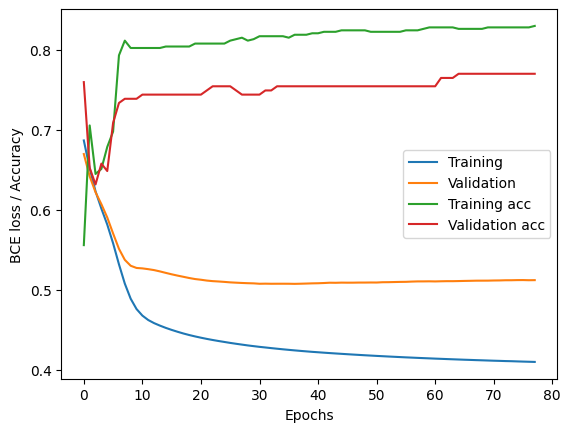

In [ ]:
loss_fn = nn.BCELoss()  # Alternatives:
                        #     Regression: MSELoss
                        #     Binary classification: BCELoss
                        #     Multi-class classification: CELoss (needs Softmax to be applied on network predictions if probabilities are needed; if only top category is needed (argmax), then no need for softmax

n_max_epochs = 200
learning_rate = 0.001
batch_size = 32
optimizer = torch.optim.Adam(bincl_model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []
best_bincl_model = None
best_val_loss = float('inf')
early_stopping_patience = 40
last_early_stopping_update_ep_idx = 0

for epoch_idx in range(n_max_epochs):

    # training
    bincl_model.train()
    train_losses_in_epoch = []
    train_accs_in_epoch = []

    for offset_idx in range(0, inputs_train_t.shape[0], batch_size):
        end_offset_idx = min(offset_idx + batch_size, inputs_train_t.shape[0])
        train_batch_xs = inputs_train_t[offset_idx:end_offset_idx, :]
        train_batch_ys = labels_train_t[offset_idx:end_offset_idx, None]

        optimizer.zero_grad()
        train_batch_ys_pred = bincl_model(train_batch_xs)
        loss = loss_fn(train_batch_ys_pred, train_batch_ys)
        acc = bin_acc_fn(train_batch_ys_pred, train_batch_ys)

        train_losses_in_epoch.append(loss.detach())    # 'loss.detach()' is stored in the list only, not 'loss' itself
                                                       #     to avoid keeping the computational graph connected to
                                                       #     all tensors stored in the 'train_losses_in_epoch' list
        train_accs_in_epoch.append(acc)                # 'acc.detach()' is not needed, as the 'acc' tensor has no computational
                                                       #     graph connected to it, since it comes from a no_grad environment
        loss.backward()
        optimizer.step()

    train_losses_in_epoch = torch.tensor(train_losses_in_epoch)
    train_accs_in_epoch = torch.tensor(train_accs_in_epoch)
    avg_tr_epoch_loss = train_losses_in_epoch.mean()    # not exactly precise because of last (possibly) incomplete batch
    avg_tr_epoch_acc = train_accs_in_epoch.mean()
    train_losses.append(avg_tr_epoch_loss)
    train_accuracy.append(avg_tr_epoch_acc)

    # validation
    bincl_model.eval()
    val_losses_in_epoch = []
    val_accs_in_epoch = []

    for offset_idx in range(0, labels_val_t.shape[0], batch_size):
        end_offset_idx = min(offset_idx + batch_size, labels_val_t.shape[0])
        val_batch_xs = inputs_val_t[offset_idx:end_offset_idx, :]
        val_batch_ys = labels_val_t[offset_idx:end_offset_idx, None]

        with torch.no_grad():                      # no need to compute gradients for validation predictions/losses
            val_batch_ys_pred = bincl_model(val_batch_xs)
        loss = loss_fn(val_batch_ys_pred, val_batch_ys)
        acc = bin_acc_fn(val_batch_ys_pred, val_batch_ys)

        val_losses_in_epoch.append(loss)    # 'loss.detach()' is not needed, again, as 'val_batch_ys_pred' was created in a no_grad environment
                                            #     therefore 'loss' has no computational graph connected to it either
        val_accs_in_epoch.append(acc)

    val_losses_in_epoch = torch.tensor(val_losses_in_epoch)
    val_accs_in_epoch = torch.tensor(val_accs_in_epoch)
    avg_val_epoch_loss = val_losses_in_epoch.mean()    # not exactly precise because of last (possibly) incomplete batch
    avg_val_epoch_acc = val_accs_in_epoch.mean()
    val_losses.append(avg_val_epoch_loss)
    val_accuracy.append(avg_val_epoch_acc)

    # logging
    print(f"Epoch #{epoch_idx}, tr loss: {avg_tr_epoch_loss}, val loss: {avg_val_epoch_loss}, tr acc: {avg_tr_epoch_acc}, val acc: {avg_val_epoch_acc}")

    # early stopping: check if current weights give the lowest ever loss
    if avg_val_epoch_loss < best_val_loss:
        best_val_loss = avg_val_epoch_loss
        best_bincl_model = copy.deepcopy(bincl_model)
        last_early_stopping_update_ep_idx = epoch_idx
        print("    Early stopping: Best model updated.")

    # early stopping: break if no update for a long time
    if last_early_stopping_update_ep_idx + early_stopping_patience < epoch_idx:
        print("Training is terminated by early stopping.")
        break

    # (end of training loop)

# restore best model (with lowest validation loss) saved by early stopping
print("Training finished. Best model weights are restored.")
bincl_model = best_bincl_model

# training has finished; evaluate trained model on test set (measure loss, accuracy on test set)
test_ys_preds = []
for offset_idx in range(0, labels_test_t.shape[0], batch_size):               # if the whole test set evaluation fits into memory, no need to do batches here, can be done in one go
    end_offset_idx = min(offset_idx + batch_size, labels_test_t.shape[0])
    test_batch_xs = inputs_test_t[offset_idx:end_offset_idx, :]
    test_batch_ys = labels_test_t[offset_idx:end_offset_idx, None]

    with torch.no_grad():                      # no need to compute gradients for validation predictions/losses
        test_batch_ys_pred = bincl_model(test_batch_xs)
        test_ys_preds.append(test_batch_ys_pred)     # not collecting losses, but all predictions
                                                     # test_batch_ys_pred.detach() is not needed, again, as we are in a no_grad environment

test_ys_preds = torch.cat(test_ys_preds, axis=0)
test_loss = loss_fn(test_ys_preds, labels_test_t[:,None])
test_acc = bin_acc_fn(test_ys_preds, labels_test_t[:,None])

print(f"Test loss: {test_loss}, test acc: {test_acc}")

# Plot training/val curves
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.plot(train_accuracy, label='Training acc')
plt.plot(val_accuracy, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('BCE loss / Accuracy')
plt.legend()
plt.show()


In [ ]:
# Check test set label category distribution to see if accuracy metric is fair or not
np.bincount(labels_test)


array([115,  64])

## Generátoros minibatch-iteráció

In [ ]:
def minibatch_generator(input_split, labels_split):
    # input_split: (n_samples, n_features), labels_split: (n_samples,)
    assert input_split.shape[:1] == labels_split.shape
    for offset_idx in range(0, input_split.shape[0], batch_size):
        train_batch_xs = input_split[offset_idx:offset_idx+batch_size, :]
        train_batch_ys = labels_split[offset_idx:offset_idx+batch_size, None]
        yield train_batch_xs, train_batch_ys


Epoch #0, tr loss: 0.687275230884552, val loss: 0.6799929738044739, tr acc: 0.5534759163856506, val acc: 0.7337962985038757
    Early stopping: Best model updated.
Epoch #1, tr loss: 0.6704582571983337, val loss: 0.6627554297447205, tr acc: 0.7779077887535095, val acc: 0.7204861640930176
    Early stopping: Best model updated.
Epoch #2, tr loss: 0.649042546749115, val loss: 0.6389095187187195, tr acc: 0.7337900996208191, val acc: 0.7204861640930176
    Early stopping: Best model updated.
Epoch #3, tr loss: 0.6210125684738159, val loss: 0.6123388409614563, tr acc: 0.7282754182815552, val acc: 0.7152778506278992
    Early stopping: Best model updated.
Epoch #4, tr loss: 0.5904629826545715, val loss: 0.5865482687950134, tr acc: 0.7282754182815552, val acc: 0.725694477558136
    Early stopping: Best model updated.
Epoch #5, tr loss: 0.5596264004707336, val loss: 0.5642299652099609, tr acc: 0.759358286857605, val acc: 0.7662037014961243
    Early stopping: Best model updated.
Epoch #6, tr l

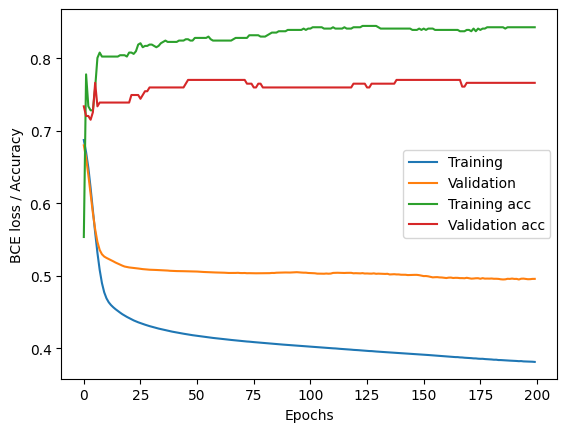

In [ ]:
loss_fn = nn.BCELoss()  # Alternatives:
                        #     Regression: MSELoss
                        #     Binary classification: BCELoss
                        #     Multi-class classification: CELoss (needs Softmax to be applied on network predictions if probabilities are needed; if only top category is needed (argmax), then no need for softmax

n_max_epochs = 200
learning_rate = 0.001
batch_size = 32
optimizer = torch.optim.Adam(bincl_model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []
best_bincl_model = None
best_val_loss = float('inf')
early_stopping_patience = 40
last_early_stopping_update_ep_idx = 0

for epoch_idx in range(n_max_epochs):

    # training
    bincl_model.train()
    train_losses_in_epoch = []
    train_accs_in_epoch = []

    for train_batch_xs, train_batch_ys in minibatch_generator(inputs_train_t, labels_train_t):
        optimizer.zero_grad()
        train_batch_ys_pred = bincl_model(train_batch_xs)
        loss = loss_fn(train_batch_ys_pred, train_batch_ys)
        acc = bin_acc_fn(train_batch_ys_pred, train_batch_ys)

        train_losses_in_epoch.append(loss.detach())    # 'loss.detach()' is stored in the list only, not 'loss' itself
                                                       #     to avoid keeping the computational graph connected to
                                                       #     all tensors stored in the 'train_losses_in_epoch' list
        train_accs_in_epoch.append(acc)                # 'acc.detach()' is not needed, as the 'acc' tensor has no computational
                                                       #     graph connected to it, since it comes from a no_grad environment
        loss.backward()
        optimizer.step()

    train_losses_in_epoch = torch.tensor(train_losses_in_epoch)
    train_accs_in_epoch = torch.tensor(train_accs_in_epoch)
    avg_tr_epoch_loss = train_losses_in_epoch.mean()    # not exactly precise because of last (possibly) incomplete batch
    avg_tr_epoch_acc = train_accs_in_epoch.mean()
    train_losses.append(avg_tr_epoch_loss)
    train_accuracy.append(avg_tr_epoch_acc)

    # validation
    bincl_model.eval()
    val_losses_in_epoch = []
    val_accs_in_epoch = []

    for val_batch_xs, val_batch_ys in minibatch_generator(inputs_val_t, labels_val_t):
        with torch.no_grad():                      # no need to compute gradients for validation predictions/losses
            val_batch_ys_pred = bincl_model(val_batch_xs)
        loss = loss_fn(val_batch_ys_pred, val_batch_ys)
        acc = bin_acc_fn(val_batch_ys_pred, val_batch_ys)

        val_losses_in_epoch.append(loss)    # 'loss.detach()' is not needed, again, as 'val_batch_ys_pred' was created in a no_grad environment
                                            #     therefore 'loss' has no computational graph connected to it either
        val_accs_in_epoch.append(acc)

    val_losses_in_epoch = torch.tensor(val_losses_in_epoch)
    val_accs_in_epoch = torch.tensor(val_accs_in_epoch)
    avg_val_epoch_loss = val_losses_in_epoch.mean()    # not exactly precise because of last (possibly) incomplete batch
    avg_val_epoch_acc = val_accs_in_epoch.mean()
    val_losses.append(avg_val_epoch_loss)
    val_accuracy.append(avg_val_epoch_acc)

    # logging
    print(f"Epoch #{epoch_idx}, tr loss: {avg_tr_epoch_loss}, val loss: {avg_val_epoch_loss}, tr acc: {avg_tr_epoch_acc}, val acc: {avg_val_epoch_acc}")

    # early stopping: check if current weights give the lowest ever loss
    if avg_val_epoch_loss < best_val_loss:
        best_val_loss = avg_val_epoch_loss
        best_bincl_model = copy.deepcopy(bincl_model)
        last_early_stopping_update_ep_idx = epoch_idx
        print("    Early stopping: Best model updated.")

    # early stopping: break if no update for a long time
    if last_early_stopping_update_ep_idx + early_stopping_patience < epoch_idx:
        print("Training is terminated by early stopping.")
        break

    # (end of training loop)

# restore best model (with lowest validation loss) saved by early stopping
print("Training finished. Best model weights are restored.")
bincl_model = best_bincl_model

# training has finished; evaluate trained model on test set (measure loss, accuracy on test set)
test_ys_preds = []

for test_batch_xs, _ in minibatch_generator(inputs_test_t, labels_test_t):    # if the whole test set evaluation fits into memory, no need to do batches here, can be done in one go
    with torch.no_grad():                      # no need to compute gradients for validation predictions/losses
        test_batch_ys_pred = bincl_model(test_batch_xs)
        test_ys_preds.append(test_batch_ys_pred)     # not collecting losses, but all predictions
                                                     # test_batch_ys_pred.detach() is not needed, again, as we are in a no_grad environment

test_ys_preds = torch.cat(test_ys_preds, dim=0)
test_loss = loss_fn(test_ys_preds, labels_test_t[:,None])
test_acc = bin_acc_fn(test_ys_preds, labels_test_t[:,None])

print(f"Test loss: {test_loss}, test acc: {test_acc}")

# Plot training/val curves
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.plot(train_accuracy, label='Training acc')
plt.plot(val_accuracy, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('BCE loss / Accuracy')
plt.legend()
plt.show()


## Betanítás a PyTorch Dataset és DataLoader osztályainak felhasználásával

In [ ]:
# instead of doing manual mini-batch iteration, use a data iterator (torch built in classes: torch.utils.data.Dataset, torch.utils.data.DataLoader)

from torch.utils.data import Dataset, DataLoader

# Custom Dataset subclass
class BinaryClassificationDataset(Dataset):
    def __init__(self, input_split, labels_split):
        self.xs = torch.tensor(input_split, dtype=torch.float32)
        self.ys = torch.tensor(labels_split, dtype=torch.float32)
        # (true) labels dtypes:
        # Regression: float32 (coninuous values)
        # Binary classification: float32 (probability)
        # Multi-class classification: int64 (category indices for CELoss)

    def __len__(self):
        return self.xs.shape[0]

    # Note: not the most efficient if data is small, batches are large (so that __getitem__ is called many times)
    def __getitem__(self, idx):
        return self.xs[idx, :], self.ys[idx, None]      # returning: (tensor(n_input_vars,), tensor(1,))
                                                        # DataLoader will yield: (tensor(batch_size, n_input_vars), tensor(batch_size, 1))




In [ ]:
# using built-in torch.utils.data.DataLoader to iterate dataset

train_dataset = BinaryClassificationDataset(inputs_train, labels_train)
val_dataset = BinaryClassificationDataset(inputs_val, labels_val)
test_dataset = BinaryClassificationDataset(inputs_test, labels_test)

dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=32, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=False)   # no need to shuffle test set! this way, the outputs from the test iterator are in the same order as the original 'test_dataset'


Epoch #0, tr loss: 0.671292781829834, val loss: 0.6666404604911804, tr acc: 0.6153074502944946, val acc: 0.6099537014961243
    Early stopping: Best model updated.
Epoch #1, tr loss: 0.6575266122817993, val loss: 0.6564345955848694, tr acc: 0.6153074502944946, val acc: 0.6018518805503845
    Early stopping: Best model updated.
Epoch #2, tr loss: 0.6417747139930725, val loss: 0.6399113535881042, tr acc: 0.6153074502944946, val acc: 0.6059027910232544
    Early stopping: Best model updated.
Epoch #3, tr loss: 0.6208410263061523, val loss: 0.6152830719947815, tr acc: 0.6161430478096008, val acc: 0.6140046119689941
    Early stopping: Best model updated.
Epoch #4, tr loss: 0.5998163819313049, val loss: 0.5984547734260559, tr acc: 0.6333556175231934, val acc: 0.6568287014961243
    Early stopping: Best model updated.
Epoch #5, tr loss: 0.5686755180358887, val loss: 0.5818830132484436, tr acc: 0.7090574502944946, val acc: 0.7309028506278992
    Early stopping: Best model updated.
Epoch #6, t

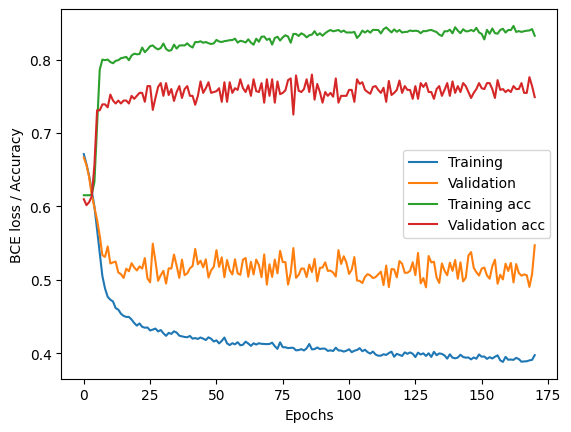

In [ ]:

loss_fn = nn.BCELoss()  # Alternatives:
                        #     Regression: MSELoss
                        #     Binary classification: BCELoss
                        #     Multi-class classification: CELoss (needs Softmax to be applied on network predictions if probabilities are needed; if only top category is needed (argmax), then no need for softmax

n_max_epochs = 200
learning_rate = 0.001
optimizer = torch.optim.Adam(bincl_model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []
best_bincl_model = None
best_val_loss = float('inf')
early_stopping_patience = 40
last_early_stopping_update_ep_idx = 0

for epoch_idx in range(n_max_epochs):

    # training
    bincl_model.train()
    train_losses_in_epoch = []
    train_accs_in_epoch = []

    for train_batch_xs, train_batch_ys in dataloader_train:

        optimizer.zero_grad()
        train_batch_ys_pred = bincl_model(train_batch_xs)
        loss = loss_fn(train_batch_ys_pred, train_batch_ys)
        acc = bin_acc_fn(train_batch_ys_pred, train_batch_ys)

        train_losses_in_epoch.append(loss.detach())    # 'loss.detach()' is stored in the list only, not 'loss' itself
                                                       #     to avoid keeping the computational graph connected to
                                                       #     all tensors stored in the 'train_losses_in_epoch' list
        train_accs_in_epoch.append(acc)                # 'acc.detach()' is not needed, as the 'acc' tensor has no computational
                                                       #     graph connected to it, since it comes from a no_grad environment
        loss.backward()
        optimizer.step()

    train_losses_in_epoch = torch.tensor(train_losses_in_epoch)
    train_accs_in_epoch = torch.tensor(train_accs_in_epoch)
    avg_tr_epoch_loss = train_losses_in_epoch.mean()    # not exactly precise because of last (possibly) incomplete batch
    avg_tr_epoch_acc = train_accs_in_epoch.mean()
    train_losses.append(avg_tr_epoch_loss)
    train_accuracy.append(avg_tr_epoch_acc)

    # validation
    bincl_model.eval()
    val_losses_in_epoch = []
    val_accs_in_epoch = []

    for val_batch_xs, val_batch_ys in dataloader_val:

        with torch.no_grad():                      # no need to compute gradients for validation predictions/losses
            val_batch_ys_pred = bincl_model(val_batch_xs)
        loss = loss_fn(val_batch_ys_pred, val_batch_ys)
        acc = bin_acc_fn(val_batch_ys_pred, val_batch_ys)

        val_losses_in_epoch.append(loss)    # 'loss.detach()' is not needed, again, as 'val_batch_ys_pred' was created in a no_grad environment
                                            #     therefore 'loss' has no computational graph connected to it either
        val_accs_in_epoch.append(acc)

    val_losses_in_epoch = torch.tensor(val_losses_in_epoch)
    val_accs_in_epoch = torch.tensor(val_accs_in_epoch)
    avg_val_epoch_loss = val_losses_in_epoch.mean()    # not exactly precise because of last (possibly) incomplete batch
    avg_val_epoch_acc = val_accs_in_epoch.mean()
    val_losses.append(avg_val_epoch_loss)
    val_accuracy.append(avg_val_epoch_acc)

    # logging
    print(f"Epoch #{epoch_idx}, tr loss: {avg_tr_epoch_loss}, val loss: {avg_val_epoch_loss}, tr acc: {avg_tr_epoch_acc}, val acc: {avg_val_epoch_acc}")

    # early stopping: check if current weights give the lowest ever loss
    if avg_val_epoch_loss < best_val_loss:
        best_val_loss = avg_val_epoch_loss
        best_bincl_model = copy.deepcopy(bincl_model)
        last_early_stopping_update_ep_idx = epoch_idx
        print("    Early stopping: Best model updated.")

    # early stopping: break if no update for a long time
    if last_early_stopping_update_ep_idx + early_stopping_patience < epoch_idx:
        print("Training is terminated by early stopping.")
        break

    # (end of training loop)

# restore best model (with lowest validation loss) saved by early stopping
print("Training finished. Best model weights are restored.")
bincl_model = best_bincl_model

# training has finished; evaluate trained model on test set (measure loss, accuracy on test set)
test_ys_preds = []
for test_batch_xs, test_batch_ys in dataloader_test:
    with torch.no_grad():                            # no need to compute gradients for validation predictions/losses
        test_batch_ys_pred = bincl_model(test_batch_xs)
        test_ys_preds.append(test_batch_ys_pred)     # not collecting losses, but all predictions
                                                     # test_batch_ys_pred.detach() is not needed, again, as we are in a no_grad environment

test_ys_preds = torch.cat(test_ys_preds, dim=0)
test_loss = loss_fn(test_ys_preds, labels_test_t[:,None])     # as the test DataLoader does not shuffle the items, the order of the inputs (and thus the predicted labels) is matching the original test set item order
test_acc = bin_acc_fn(test_ys_preds, labels_test_t[:,None])   #       -> do not do this if the DataLoader shuffles the items

print(f"Test loss: {test_loss}, test acc: {test_acc}")

# Plot training/val curves
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.plot(train_accuracy, label='Training acc')
plt.plot(val_accuracy, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('BCE loss / Accuracy')
plt.legend()
plt.show()
